# Sparse Regression in HTG Mouse Series

The idea here is to regress the genotyped CAG length using the gene expression data.  To do this we'll use a simple sparse regression technique.  The elastic net is a ridge + lasso penalized linear regression, and glmnet imlpements a very nice version.

## Required Packages

* caret makes splitting the data up in to test and train groups easy
* ggplot2 for ggplots
* glmnet for regression
* tidyr for data frame manipulation

In [4]:
packages <- c('caret',
              'ggplot2',
              'glmnet',
              'tidyr',
              'JGL',
              'igraph',
              'huge',
              'matrixStats'
             )

# load package is it exists, if not, install it and then load it
for (package in packages) {
    if (!require(package, character.only=TRUE, quietly=TRUE)) {
        install.packages(package, repos='http://cran.us.r-project.org')
        require(package, character.only=TRUE, quietly=TRUE)
    }
}

(.packages())

[1] "matrixStats" "huge"        "MASS"        "JGL"         "igraph"     
 [6] "tidyr"       "glmnet"      "foreach"     "Matrix"      "caret"      
[11] "ggplot2"     "lattice"     "stats"       "graphics"    "grDevices"  
[16] "utils"       "datasets"    "methods"     "base"

## Load up data

different normalizations i've prepared:
* raw counts
* nonparanormal
* log(raw counts + 1)

In [2]:
data_dir <- "/users/rdonovan/shared_data/hd_mouse_allelic_series"
data_files_to_load <- list.files(path=data_dir)

In [3]:
for (data_file in data_files_to_load) {
    full_data_path <- file.path(data_dir,data_file)
    print(full_data_path)
    load(full_data_path)
}

load('~/shared_data/hd_mouse_allelic_series/htg_gene_names.Rdata')

ls()

[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_LOG.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_NPN.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_RAW.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_LOG.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_NPN.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_RAW.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/htg_gene_names.Rdata"


[1] "all_mrna_data_logp1"    "all_mrna_data_npn"      "all_mrna_data_npn_tidy"
 [4] "all_mrna_data_raw"      "all_mrna_data_raw_tidy" "data_dir"              
 [7] "data_file"              "data_files_to_load"     "full_data_path"        
[10] "genesEntrez"            "genesNames"             "package"               
[13] "packages"               "q"                      "quit"

## Modify data slightly

The wt mice all have q-length of 7, but aren't annotated correctly in the data (I think), so fix that

we'll use the log transformed counts, though better normalizations are certainly possible

In [5]:
wt_mice_inds <- (all_mrna_data_logp1$GenoType == 'WT')
all_mrna_data_logp1[wt_mice_inds,c('Genotyped.CAG')] <- 7
all_mrna_data_logp1[wt_mice_inds,c('Numeric.Q')] <- 7

table(all_mrna_data_logp1$Numeric.Q)


  7  20  80  92 111 140 175 
112  72  71  72  72  72  72 

### Use only metabolic genes

In [6]:
metabolic_genes <- read.csv('/users/rdonovan/shared_data/CONVERTED_MOUSE_IDS.csv')
metabolic_genes_entrez <- metabolic_genes[,1] %>% lapply(as.character) %>% sapply(paste0, collapse="")

In [7]:
metabolic_gene_names <- genesNames[metabolic_genes_entrez]
metabolic_gene_names <- metabolic_gene_names[!is.na(metabolic_gene_names)]

In [8]:
metabolic_mrna_data_logp1 <- cbind(all_mrna_data_logp1[1:11],all_mrna_data_logp1[c(metabolic_gene_names)])

In [9]:
head(metabolic_mrna_data_logp1[1:20])

,PGI.Mouse.ID,observationid,Tissue,Seq.Type,GenoType,Housing.Conditions,Numeric.Q,Sex,Genotyped.CAG,Month,Sample.ID,Ldhd,C1galt1,Ddo,Maob,Scd1,Folr1,Cox5b,Slc5a10,Cox5a
645,Q20B0009.08,X300195_Q20B0009_08_L1.D707,liver,mRNA,HET (Q20),Housed with Q20 and WT animals,20,MALE,19.9738,10,X300195_Q20B0009_08_L1.D707,8.80597465931132,6.58202513889283,6.43133108193348,8.78446845409036,11.5048630508802,0.693147180559945,7.04228617193974,0,8.20357773693795
384,Q20B0013.05,X300196_Q20B0013_05_L1.D708,liver,mRNA,WT,Housed with Q20 and WT animals,7,FEMALE,7,10,X300196_Q20B0013_05_L1.D708,8.33973976601914,6.5410299991899,6.41673228251233,9.45805945585643,12.3745530202502,0.693147180559945,7.11639414409346,0,8.155649270366
656,Q20B0009.03,X300197_Q20B0009_03_L1.D709,liver,mRNA,WT,Housed with Q20 and WT animals,7,MALE,7,10,X300197_Q20B0009_03_L1.D709,8.59304250369967,6.17586727010576,6.30627528694802,8.86644061952617,12.4069010558274,0.693147180559945,7.1074254741107,0,8.18785544369562
657,Q92B0005.05,X300198_Q92B0005_05_L1.D710,liver,mRNA,HET (Q92),Housed with Q92 and WT animals,92,FEMALE,102.467,10,X300198_Q92B0005_05_L1.D710,8.29304913976844,6.22059017009974,6.77308037565554,9.36211680694198,12.3472075579939,1.09861228866811,7.13886699994552,0.693147180559945,8.21608809863232
658,Q140B0001.08,X300199_Q140B0001_08_L1.D711,liver,mRNA,HET (Q140),Housed with Q140 and WT animals,140,MALE,148.267,10,X300199_Q140B0001_08_L1.D711,8.98744678941718,6.74993119378857,6.59441345974978,9.02941783609594,12.2893056434272,1.6094379124341,7.18387071506245,0,8.28324144138542
659,Q92B0006.05,X300200_Q92B0006_05_L29,liver,mRNA,HET (Q92),Housed with Q92 and WT animals,92,FEMALE,101.695,10,X300200_Q92B0006_05_L29,8.10046489102936,6.23048144757848,6.5510803350434,9.40508444876869,12.6696494166956,0,7.01660968389422,0.693147180559945,8.02191277898571


In [10]:
dim(metabolic_mrna_data_logp1)

[1]  543 1397

## Subset out different tissues / time-points

This seems like a reasonable problem to start with: for the 10 month mice, can we use the gene expression in striatum to predict the CAG length of the mouse?

We'll also make some other subsets, to play with later

In [11]:
cortex_2_condition <- (metabolic_mrna_data_logp1$Tissue == "cortex") & (metabolic_mrna_data_logp1$Month == 2)
data_subset_cortex_2 <- metabolic_mrna_data_logp1[cortex_2_condition,]                  
dim(data_subset_cortex_2)

striatum_2_condition <- (metabolic_mrna_data_logp1$Tissue == "striatum") & (metabolic_mrna_data_logp1$Month == 2)
data_subset_striatum_2 <- metabolic_mrna_data_logp1[striatum_2_condition,]                  
dim(data_subset_striatum_2)

liver_2_condition <- (metabolic_mrna_data_logp1$Tissue == "liver") & (metabolic_mrna_data_logp1$Month == 2)
data_subset_liver_2 <- metabolic_mrna_data_logp1[liver_2_condition,]                  
dim(data_subset_liver_2)

cortex_6_condition <- (metabolic_mrna_data_logp1$Tissue == "cortex") & (metabolic_mrna_data_logp1$Month == 6)
data_subset_cortex_6 <- metabolic_mrna_data_logp1[cortex_6_condition,]                  
dim(data_subset_cortex_6)

striatum_6_condition <- (metabolic_mrna_data_logp1$Tissue == "striatum") & (metabolic_mrna_data_logp1$Month == 6)
data_subset_striatum_6 <- metabolic_mrna_data_logp1[striatum_6_condition,]                  
dim(data_subset_striatum_6)

liver_6_condition <- (metabolic_mrna_data_logp1$Tissue == "liver") & (metabolic_mrna_data_logp1$Month == 6)
data_subset_liver_6 <- metabolic_mrna_data_logp1[liver_6_condition,]                  
dim(data_subset_liver_6)

cortex_10_condition <- (metabolic_mrna_data_logp1$Tissue == "cortex") & (metabolic_mrna_data_logp1$Month == 10)
data_subset_cortex_10 <- metabolic_mrna_data_logp1[cortex_10_condition,]                  
dim(data_subset_cortex_10)

striatum_10_condition <- (metabolic_mrna_data_logp1$Tissue == "striatum") & (metabolic_mrna_data_logp1$Month == 10)
data_subset_striatum_10 <- metabolic_mrna_data_logp1[striatum_10_condition,]                  
dim(data_subset_striatum_10)

liver_10_condition <- (metabolic_mrna_data_logp1$Tissue == "liver") & (metabolic_mrna_data_logp1$Month == 10)
data_subset_liver_10 <- metabolic_mrna_data_logp1[liver_10_condition,]                  
dim(data_subset_liver_10)

[1]   56 1397

[1]   56 1397

[1]   56 1397

[1]   56 1397

[1]   96 1397

[1]   56 1397

[1]   56 1397

[1]   56 1397

[1]   55 1397

In [12]:
my_data_subset <- data_subset_striatum_6

In [13]:
table(my_data_subset$Numeric.Q)


  7  20  80  92 111 140 175 
 48   8   8   8   8   8   8 

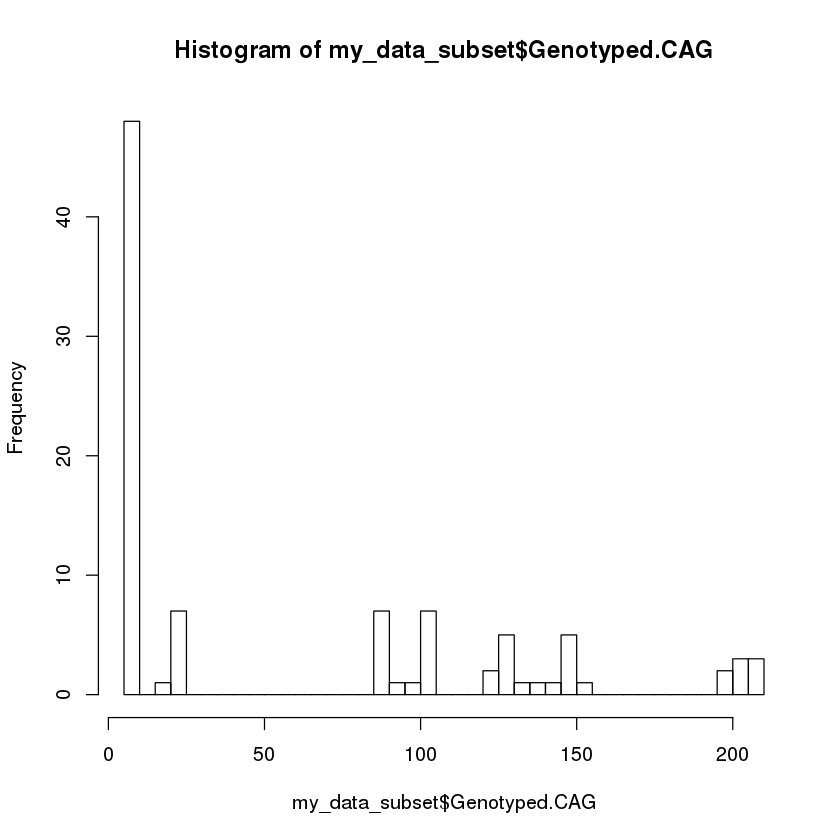

In [14]:
hist(my_data_subset$Genotyped.CAG, breaks=50)

## prepare data matrices for glmnet

In [23]:
y <- my_data_subset$Genotyped.CAG
y_q <- my_data_subset$Numeric.Q
X <- as.matrix(my_data_subset[-c(1:11)])
length(y)
dim(X)

[1] 96

[1]   96 1386

## split data into test/train and holdout
we'll look for good model parameters using cross validation on the 75% of the data in the test/train partition, and then train a final model on all of that 75% of the data, and finally test it on the held-out data that the model/parameter scan has never seen. createDataPartition does a balanced split, which is nice.

In [24]:
test_train_inds <- createDataPartition(y, p=0.75, groups=length(table(y_q)))

X_test_train <- X[test_train_inds$Resample1,]
y_test_train <- y[test_train_inds$Resample1]
X_holdout <- X[-test_train_inds$Resample1,]
y_holdout <- y[-test_train_inds$Resample1]

## scan over sparity values in the test/train data

the alpha value decides on the balance between the rdge and lasso penalties.  ridge encourages moderate coefficinet valies, and lasso encourages sparsity.

In [25]:
alpha_values <- seq(0,1,0.1)

cv_info <- data.frame()

for (alpha_value in alpha_values){
    fit.cv <- cv.glmnet(X_test_train, y_test_train, 
                        alpha = alpha_value, family='gaussian', type.measure = "deviance"
                       )
        
    best_lambda_index_lse <- match(fit.cv$lambda.1se, fit.cv$lambda)
    best_lambda_index_min <- match(fit.cv$lambda.min, fit.cv$lambda)
    cv_info <- rbind(cv_info, data.frame(
                                            alpha=alpha_value,
                                            lowest_lse=fit.cv$cvm[best_lambda_index_lse],
                                            nonzero_params_lse=fit.cv$nzero[best_lambda_index_lse],
                                            lowest_mse=fit.cv$cvm[best_lambda_index_min],
                                            nonzero_params_mse=fit.cv$nzero[best_lambda_index_min]
                                        )
                    )
}

### pick a good alpha parameter

we can look at the cross-validated accuracy of the model at different alpha values  and pick a value we like.  usually this in the one with the lowest mean squared eror and a reasonable amount of sparsity.

In [26]:
cv_info
best_alpha <- cv_info$alpha[(match(min(cv_info$lowest_mse), cv_info$lowest_mse))]
best_alpha

,alpha,lowest_lse,nonzero_params_lse,lowest_mse,nonzero_params_mse
s79,0.000,1093.919,1371.000,932.198,1371.000
s41,0.100,1135.547,60.000,1023.403,97.000
s33,0.200,1267.291,30.000,1108.379,53.000
s36,0.300,1199.069,23.000,1085.979,57.000
s331,0.400,1185.060,17.000,1018.975,42.000
s361,0.500,1164.019,15.000,1053.963,31.000
s32,0.600,1288.089,12.000,1151.222,21.000
s30,0.700,1246.859,10.000,1096.019,29.000
s29,0.800,1248.907,6.000,1082.727,16.000
s362,0.9000,1026.4949,9.0000,918.1954,23.0000


[1] 0.9

to have good confidence we're not overfitting, we should proabably have fewer coefficients than data points

In [27]:
best_alpha <- 0.9

## look at CV performace at chosen alpha

In [28]:
fit.cv <- cv.glmnet(X_test_train, y_test_train, 
                        alpha = best_alpha, family='gaussian', type.measure = "deviance"
                       )

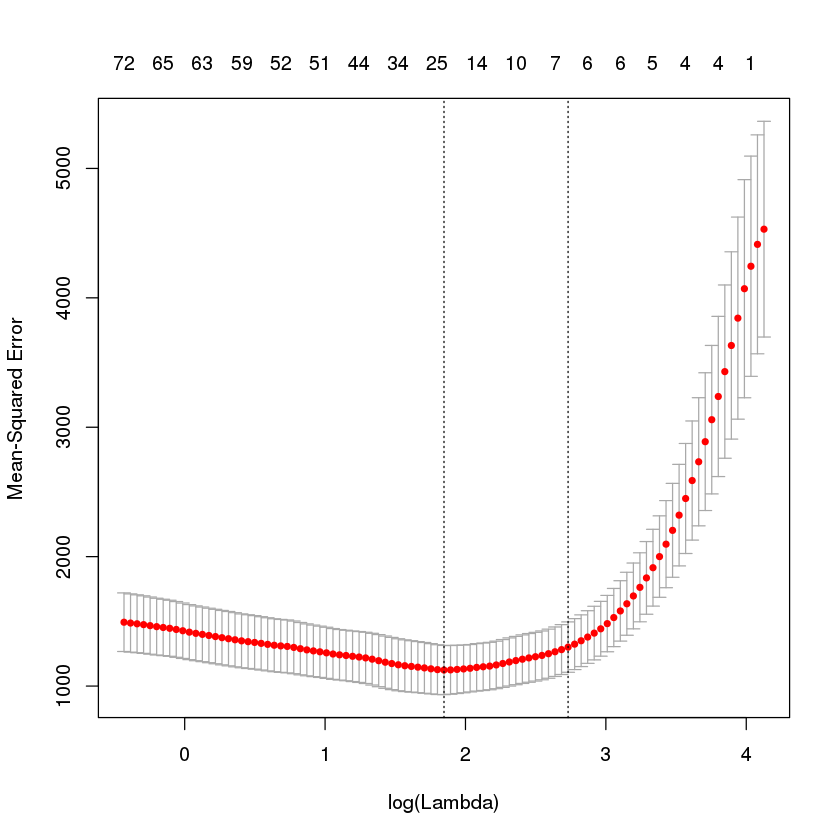

In [29]:
plot(fit.cv)

## train a final model on all the test/train data

In [30]:
fit = glmnet(X_test_train, y_test_train, alpha = best_alpha, family = 'gaussian')

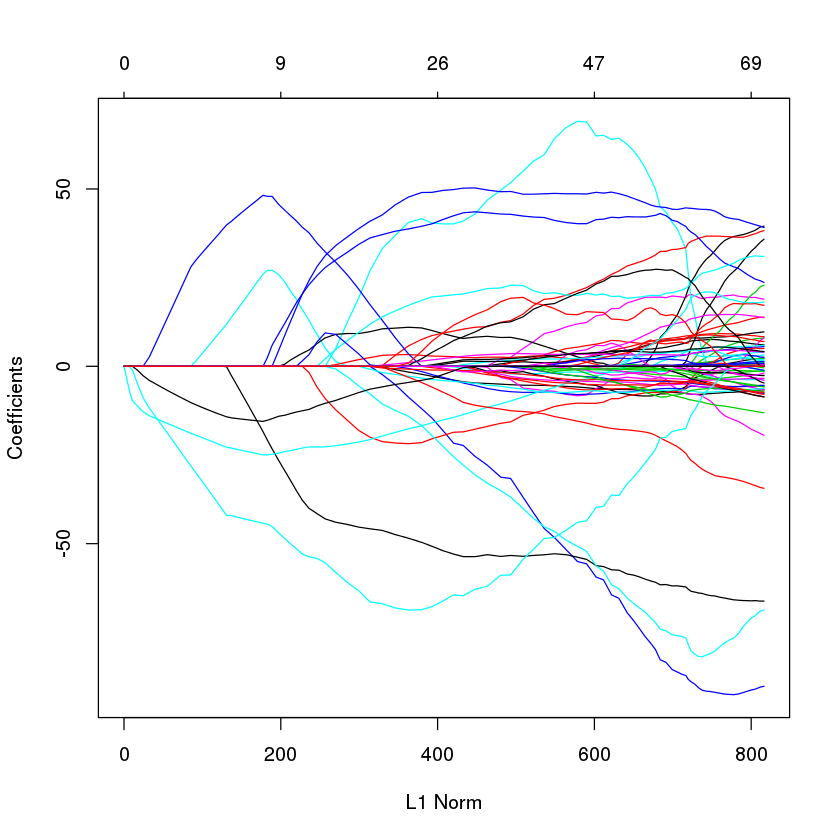

In [31]:
plot(fit)

## pick out the best model and predict with it

glmnet trains along a "lambda path" with increasing sparsity, so we need to pick the one appropriately sparse model we want.  we'll do this using the best lamda paramter from cross-validated model above.

## predictions

In [32]:
# best sparsity parameter form CV
best_lambda_index <- match(fit.cv$lambda.1se, fit.cv$lambda)

# predict on the held-out data
preds <- predict(fit, X_holdout)
y_pred <- preds[,best_lambda_index]

# create df for plotting
df_pred_perf <- data.frame(
    predicted.CAGlength=y_pred,
    actual.CAGlength=y_holdout,
    Numeric.Q=as.factor(my_data_subset$Numeric.Q[-test_train_inds$Resample1])
)


# predict on the training data, just for visualizing
preds_overfit <- predict(fit, X_test_train)
y_pred_overfit <- preds_overfit[,best_lambda_index]

# create df for plotting
df_overfit <- data.frame(
    predicted.CAGlength=y_pred_overfit,
    actual.CAGlength=y_test_train,
    Numeric.Q=as.factor(my_data_subset$Numeric.Q[test_train_inds$Resample1])
)

In [33]:
p_all <- ggplot(df_pred_perf,aes(x=actual.CAGlength, y=predicted.CAGlength)) + 

# training data
geom_point(
    data=df_overfit,
    aes(
        x=actual.CAGlength,
        y=predicted.CAGlength
        ),
    alpha = 0.1
) +

# held out data
geom_point(
    data=df_pred_perf,
    aes(colour=Numeric.Q),
    alpha = 1.0
) +

# ooh a line
stat_smooth(method = "lm", formula = y ~ x, colour="darkgrey") +

# styling
theme_minimal() +
theme(legend.position = "bottom") +
guides(col = guide_legend(nrow = 1))

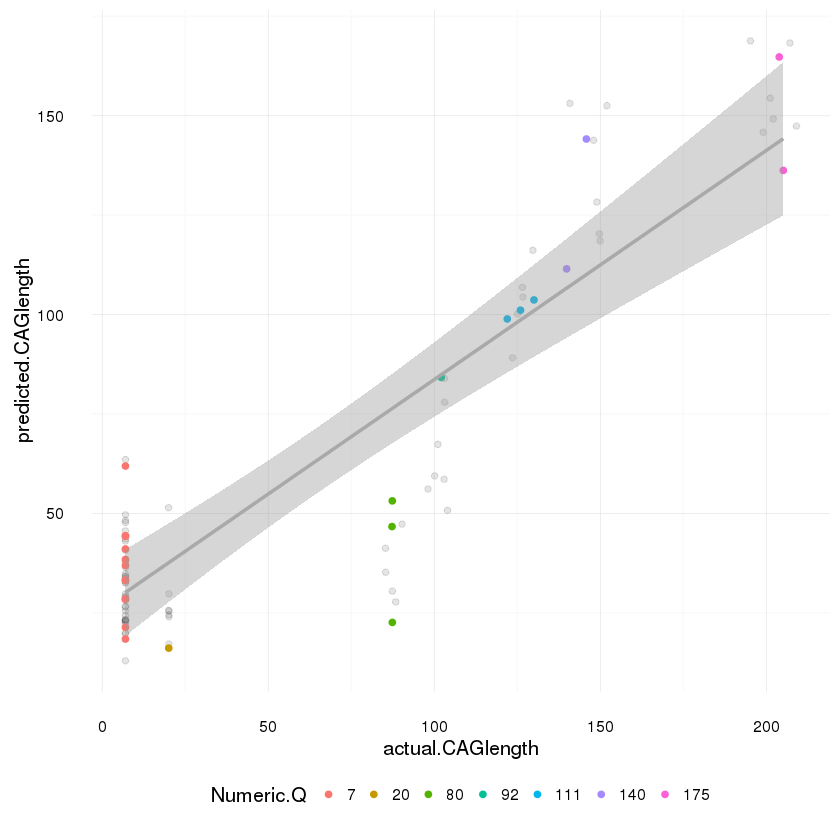

In [34]:
p_all

## pull out the nonzero coefficients and look at those genes

In [35]:
best_betas <- fit$beta[,best_lambda_index]
degs <- best_betas[best_betas != 0.0]

### make a tidy data frame of the degs for plotting

In [36]:
deg_df_log <- cbind(Numeric.Q=y_q,data.frame(X[,names(degs)]))
deg_df_log_tidy <- gather(deg_df_log, 'Gene', 'Expression', -Numeric.Q)

### plot DEG expression for each gene colored by Q length

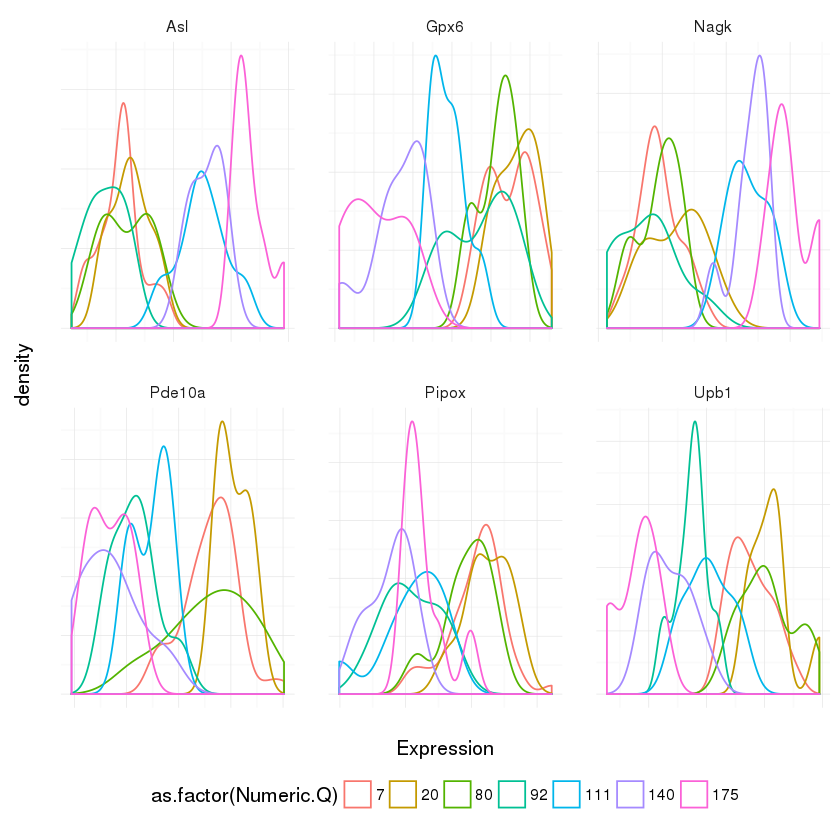

In [37]:
p_deg_log <- ggplot(deg_df_log_tidy) + 
    geom_density(aes(Expression, colour = as.factor(Numeric.Q))) +
    theme_minimal() + 
    theme(
        legend.position = "bottom",
        axis.ticks = element_blank(),
        axis.text = element_blank()
         ) +
    guides(col = guide_legend(nrow = 1))


p_deg_log + facet_wrap(~ Gene, scales = "free")

In [38]:
names(degs)

[1] "Nagk"   "Pipox"  "Gpx6"   "Asl"    "Pde10a" "Upb1"

# Joint graphical glasso

## Metaboloc Genes

In [52]:
X <- my_data_subset[,-c(1:11)]
X <- X[,colSums(X == 0) == 0]
X <- cbind(my_data_subset[,c(1:11)],X)

In [211]:
M1 <- as.matrix(X[X$Numeric.Q < 80,-c(1:11)])
rownames(M1) <- NULL 
M1 <- huge.npn(M1)

M2 <- as.matrix(X[X$Numeric.Q > 80,-c(1:11)])
rownames(M2) <- NULL
M2 <- huge.npn(M2)

my_data <- list(M1,M2)

Conducting the nonparanormal (npn) transformation via shrunkun ECDF....done.
Conducting the nonparanormal (npn) transformation via shrunkun ECDF....done.


In [212]:
str(my_data)

List of 2
 $ : num [1:56, 1:1227] -1.4312 1.3226 0.6693 -0.1164 0.0465 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:1227] "Ldhd" "C1galt1" "Ddo" "Maob" ...
 $ : num [1:32, 1:1227] -0.2075 0.124 1.1184 0.8677 0.0412 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:1227] "Ldhd" "C1galt1" "Ddo" "Maob" ...


In [219]:
ggl.results = JGL(Y=my_data,penalty="group",lambda1=0.95,lambda2=.001,return.whole.theta=FALSE)

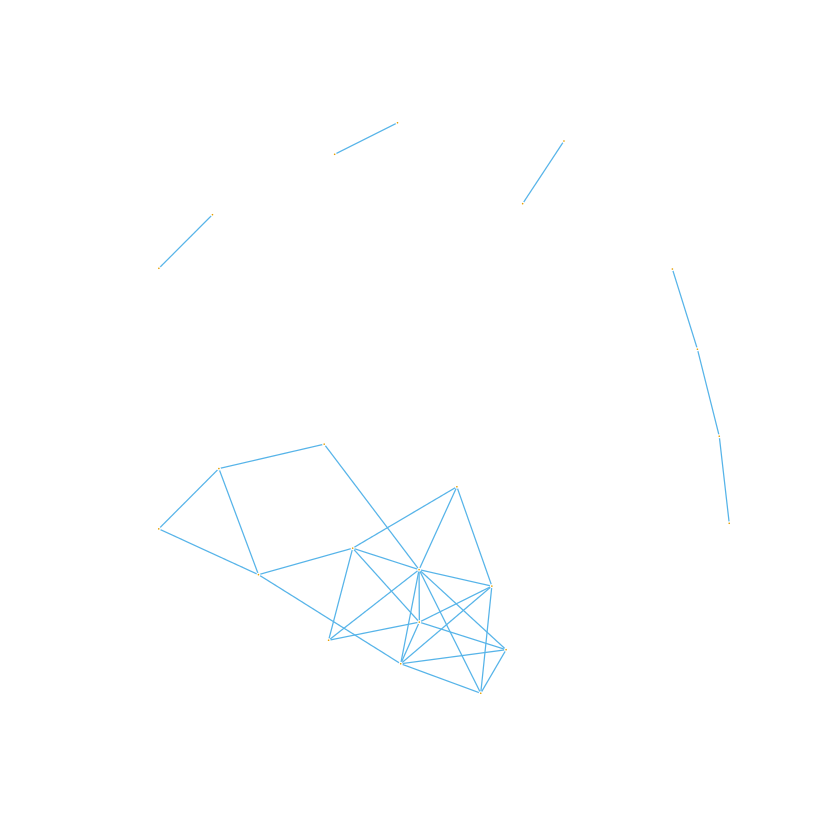

In [220]:
plot.jgl(ggl.results)

In [221]:
str(ggl.results)

List of 3
 $ theta            :List of 2
  ..$ : num [1:23, 1:23] 1.02 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:23] "Pdha1" "Etnk1" "Pkm" "Pafah1b1" ...
  .. .. ..$ : chr [1:23] "Pdha1" "Etnk1" "Pkm" "Pafah1b1" ...
  ..$ : num [1:23, 1:23] 1.03 0 0 0 0 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:23] "Pdha1" "Etnk1" "Pkm" "Pafah1b1" ...
  .. .. ..$ : chr [1:23] "Pdha1" "Etnk1" "Pkm" "Pafah1b1" ...
 $ theta.unconnected:List of 2
  ..$ : Named num [1:1204] 1.02 1.02 1.02 1.02 1.02 ...
  .. ..- attr(*, "names")= chr [1:1204] "Ldhd" "C1galt1" "Ddo" "Maob" ...
  ..$ : Named num [1:1204] 1.03 1.04 1.03 1.04 1.03 ...
  .. ..- attr(*, "names")= chr [1:1204] "Ldhd" "C1galt1" "Ddo" "Maob" ...
 $ connected        : logi [1:1227] FALSE FALSE FALSE FALSE FALSE FALSE ...
 - attr(*, "class")= chr "jgl"


In [222]:
ig1 <- graph.adjacency(ggl.results$theta[[1]], mode="undirected", weighted=TRUE, diag = FALSE)
ig2 <- graph.adjacency(ggl.results$theta[[2]], mode="undirected", weighted=TRUE, diag = FALSE)

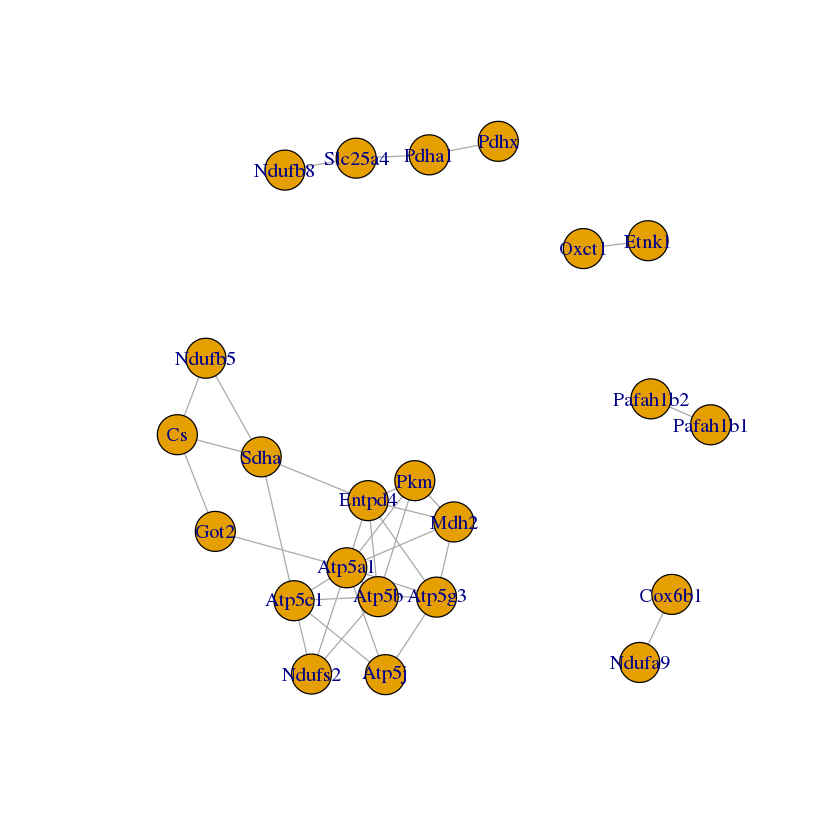

In [228]:
plot(ig2)

In [229]:
cc <- components(ig2)

for (c in 1:length(unique(cc$membership))) {
    print(names(cc$membership)[cc$membership == c])
}

[1] "Pdha1"   "Ndufb8"  "Pdhx"    "Slc25a4"
[1] "Etnk1" "Oxct1"
 [1] "Pkm"    "Atp5g3" "Ndufs2" "Got2"   "Entpd4" "Mdh2"   "Cs"     "Atp5b" 
 [9] "Atp5c1" "Atp5a1" "Atp5j"  "Ndufb5" "Sdha"  
[1] "Pafah1b1" "Pafah1b2"
[1] "Ndufa9" "Cox6b1"


In [230]:
names(cc$membership)

[1] "Pdha1"    "Etnk1"    "Pkm"      "Pafah1b1" "Pafah1b2" "Atp5g3"  
 [7] "Ndufa9"   "Ndufs2"   "Got2"     "Entpd4"   "Mdh2"     "Oxct1"   
[13] "Cs"       "Ndufb8"   "Pdhx"     "Atp5b"    "Atp5c1"   "Atp5a1"  
[19] "Atp5j"    "Slc25a4"  "Ndufb5"   "Sdha"     "Cox6b1"

In [231]:
names(cc$membership)[cc$membership == 3]

[1] "Pkm"    "Atp5g3" "Ndufs2" "Got2"   "Entpd4" "Mdh2"   "Cs"     "Atp5b" 
 [9] "Atp5c1" "Atp5a1" "Atp5j"  "Ndufb5" "Sdha"

## All genes

In [99]:
striatum_6_condition <- (all_mrna_data_logp1$Tissue == "striatum") & (all_mrna_data_logp1$Month == 6)
data_subset_striatum_6 <- all_mrna_data_logp1[striatum_6_condition,]                  
dim(data_subset_striatum_6)

[1]    96 23362

In [100]:
my_data_subset <- data_subset_striatum_6

In [101]:
X <- my_data_subset

In [109]:
M1 <- as.matrix(X[X$Numeric.Q < 80,-c(1:11)])
M2 <- as.matrix(X[X$Numeric.Q > 80,-c(1:11)])

M1_zerovars <- colVars(M1) == 0
M2_zerovars <- colVars(M2) == 0

zero_var_within_class_genes <- (M1_zerovars | M2_zerovars)
pos_var_within_class_gene_names <- (colnames(M1)[!zero_var_within_class_genes])

M1 <- M1[,pos_var_within_class_gene_names]
M2 <- M2[,pos_var_within_class_gene_names]

In [110]:
rownames(M1) <- NULL 
M1 <- huge.npn(M1)

rownames(M2) <- NULL
M2 <- huge.npn(M2)

my_data <- list(M1,M2)

Conducting the nonparanormal (npn) transformation via shrunkun ECDF....done.
Conducting the nonparanormal (npn) transformation via shrunkun ECDF....done.


In [111]:
str(my_data)

List of 2
 $ : num [1:16, 1:20173] 0.961 -0.351 -0.845 0.961 -1.39 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:20173] "0610005C13Rik" "0610007N19Rik" "0610007P14Rik" "0610009B14Rik" ...
 $ : num [1:64, 1:20173] -0.98 0.268 -0.485 0.531 0.805 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:20173] "0610005C13Rik" "0610007N19Rik" "0610007P14Rik" "0610009B14Rik" ...


In [ ]:
ggl.results = JGL(Y=my_data,penalty="fused",lambda1=0.95,lambda2=.001,return.whole.theta=FALSE)

In [50]:
ig1 <- graph.adjacency(ggl.results$theta[[1]], mode="undirected", weighted=TRUE, diag = FALSE)
ig2 <- graph.adjacency(ggl.results$theta[[2]], mode="undirected", weighted=TRUE, diag = FALSE)

In [53]:
str(ig2)

IGRAPH U--- 0 0 -- 
